# Global historical temperature

The US National Atmospheric and Oceanic Administration (NOAA)
maintains a large curated collection of weather data called the
"Global Historical Climatology Network", or GHCN. The data we
consider here are a subset of the GHCN, consisting of daily maximum
and minimum temperatures, recorded at roughly 180 locations
(stations) around the world.

In addition to the temperature data, we also have the latitude,
longitude, and elevation of each station.  These data can be used to
address a number of important questions relating to variation in
weather and climate over time and in different geographic locations.

The data considered here are all quantitative.  Therefore we will be
using methods for analyzing quantitative data, including measures of
location and scale, scatterplots, boxplots, and scatterplot
smoothing.

These are the modules that we will be using:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

The following code is needed to make plots using timestamp data.

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Modify this string according to your section number (001 or 002):

In [3]:
f = "stats206s002f21"

Next we read the data from a file.

In [33]:
base = "/scratch/%s_class_root/%s_class/shared_data/datasets" % (f, f)
df = pd.read_csv(os.path.join(base, "ghcnd_gsn.csv.gz"))
print(df.shape)

(3000669, 7)


We need to convert the date variable to a timestamp, otherwise it
will be in text format which is not as easy to work with.

In [5]:
df["date"] = pd.to_datetime(df["date"])

It can be useful to insert logic checks such as the one below into
your code.  The minimum temperature at one location for one day can
never be greater than the maximum temperature for the same location
on the same day.

In [6]:
assert(all(df.tmax >= df.tmin))

The data records for different stations start and end at different
times.  The average station has around 43 years of data.  The
following plot shows us the beginning and end of the data record for
each station

Text(0, 0.5, 'Last year')

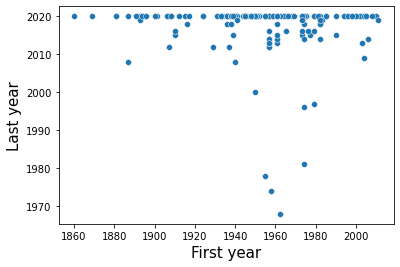

In [7]:
df["year"] = df["date"].dt.year
r = df.groupby("id")["year"].agg(["min", "max"])
plt.clf()
sns.scatterplot(x="min", y="max", ci=None, data=r)
plt.xlabel("First year", size=15)
plt.ylabel("Last year", size=15)

The above plot shows us that most of the stations in our dataset
have data going up to 2019 or 2020, although a few stop much
earlier.  However the starting years vary substantially among the
stations.  Note that this plot shows the date of the earliest and
latest record for each station, but there is no guarantee that there
is data for every single day between these two dates.

Below we plot the locations of the stations.  Looking closely, you
should be able to see that the stations fall on all seven
continents.

(3000669, 9)
(197, 2)


Text(0, 0.5, 'Latitude')

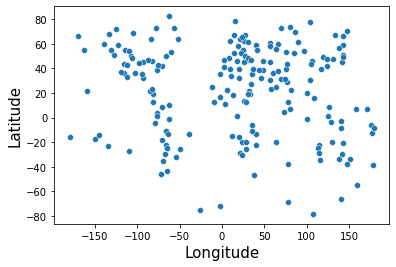

In [24]:
plt.clf()
dx = df.loc[:, ["lon", "lat"]].drop_duplicates()
print(df.shape)
print(dx.shape)
sns.scatterplot(x="lon", y="lat", ci=None, data=dx)
plt.xlabel("Longitude", size=15)
plt.ylabel("Latitude", size=15)

As an initial analysis, we take the stations that are at a similar
latitude to Ann Arbor, Michigan (between 40 and 45 degrees north
latitude).  We then stratify by month, and make boxplots showing the
distributions of daily maximum temperatures within each month for
these stations.

10


<AxesSubplot:xlabel='month', ylabel='tmax'>

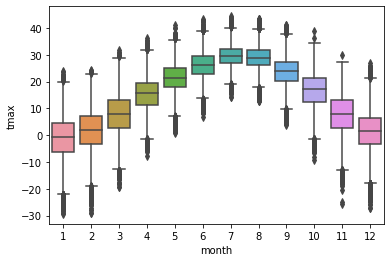

In [23]:
dx = df.loc[(df["lat"] >= 40) & (df["lat"] <= 45), :].copy()
print(dx["id"].unique().size)
dx["month"] = dx["date"].dt.month
sns.boxplot(x="month", y="tmax", data=dx)

The boxplots above show the expected pattern of temperature
variation throughout the year.  Specifically, the median and both
the 25th and 75th percentiles exhibit lower temperatures in the
winter and warmer temperatures in the summer.  While this is the
most prominent feature of the above plot, it is also notable that
the dispersion is greater in the winter than in the summer.  As an
example of why this difference in dispersions ("heteroscedasticity")
exists, consider Portland, Oregon and Ann Arbor, Michigan, which are
at similar latitudes.  However Portland is near the Pacific Ocean
which moderates its temerature, especially in winter.  While Ann
Arbor typically has temperatures that remain below zero during
January, Portland does not.  On the other hand, Portland and Ann
Arbor have quite similar temperatures in the summer.

By contrast to the above plot, if we select stations near the
equator we get a very different result:

19


<AxesSubplot:xlabel='month', ylabel='tmax'>

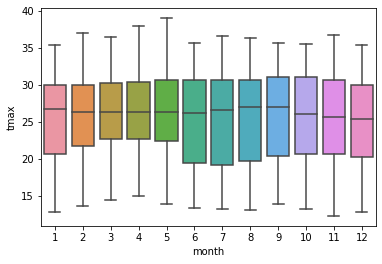

In [22]:
dx = df.loc[(df["lat"] >= -10) & (df["lat"] <= 10), :].copy()
print(dx["id"].unique().size)
dx["month"] = dx["date"].dt.month
sns.boxplot(x="month", y="tmax", data=dx)

## Annual temperature extremes

In any given location, within each year the "temperature extremes"
are the coldest and warmest temperatures that occur.  Next we
compute these extremes.  Specifically, we calculate the minimum of
the daily minimum temperatures, and the maximum of the daily maximum
temperatures, over all days within each year at each station.  The
result is a summarized dataset that contains two numbers for each
station/year, corresponding to the coldest and warmest temperatures
recorded at that location in one specific year.

In [11]:
r = df.groupby(["id", "year"]).aggregate({"tmax": np.max, "tmin": np.min, "lat": "first", "elev": "first"})
r = r.reset_index()
print(r.shape)

(11638, 6)


Next we make a scatterplot showing the relationship between the
maximum temperature extreme, at each location/year and the latitude
of the location. Since there are many points, we plot with a small
alpha (transparency) value to reduce overplotting.

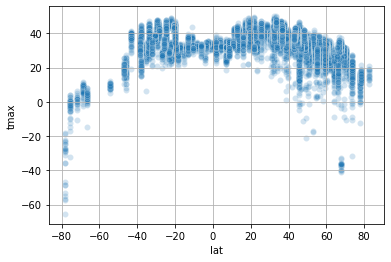

In [12]:
sns.scatterplot(x="lat", y="tmax", ci=None, alpha=0.2, data=r)
plt.ylabel("tmax")
plt.grid(True)

This plot becomes more informative if we include an estimate of the
conditional mean trend, obtained using the lowess procedure:

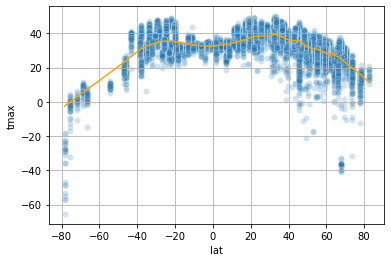

In [13]:
r["tmax_smooth_lat"] = sm.nonparametric.lowess(r["tmax"], r["lat"], frac=0.2, return_sorted=False)
sns.scatterplot(x="lat", y="tmax", ci=None, alpha=0.2, data=r)
sns.lineplot(x="lat", y="tmax_smooth_lat", color="orange", ci=None, data=r)
plt.ylabel("tmax")
plt.grid(True)

The pattern above reflects the fact that temperatures are warmest in
the tropical bands just north and south of the equator, and decrease
as we move toward either the north or the south pole.  Locations
very close to the equator are slightly cooler than areas around 25
degrees north or south of the equator.

We can also consider the relationship between maximum temperature
and elevation.

(0.0, 55.775)

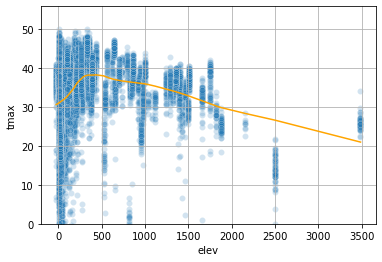

In [14]:
r["tmax_smooth_elev"] = sm.nonparametric.lowess(r["tmax"], r["elev"], return_sorted=False)
sns.scatterplot(x="elev", y="tmax", ci=None, alpha=0.2, data=r)
sns.lineplot(x="elev", y="tmax_smooth_elev", color="orange", ci=None, data=r)
plt.ylabel("tmax")
plt.grid(True)
plt.ylim(ymin=0)

Here we see that the conditional mean of the annual maximum
temperature is highest at moderate elevation, lower near zero
elevation, which tends to be in coastal areas, and very low at high
elevations.  Locations at very low elevation tend to be near the
ocean, and as a result have somewhat moderated temperatures compared
to more inland regions.

### Scatter and conditional dispersion

The "scatter" in a scatterplot reflects the degree of conditional
dispersion of the data values around the mean.  In the plot above
that shows maximum temperature in relation to latitude, we see
somewhat less dispersion near the equator.

To investigate the conditional dispersion more formally, we can make
a scatterplot of the absolute values of the residuals, and smooth it
using lowess. To make residuals in a scatterplot, we take the
variable that is plotted on the vertical axis, and subtract from it
its fitted value obtained using lowess.  By then smoothing the
absolute residuals, we are estimating the dispersion "local" to each
latitude value.  We will limit the vertical axis range to more
clearly see the shape of the smoothed curve.

Text(0, 0.5, 'Absolute residual')

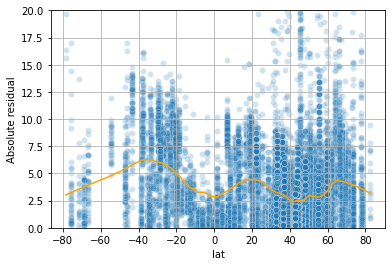

In [15]:
r["resid"] = r["tmax"] - r["tmax_smooth_lat"]
r["absresid"] = np.abs(r["resid"])
r["absresid_smooth"] = sm.nonparametric.lowess(r["absresid"], r["lat"], frac=0.2, return_sorted=False)
plt.clf()
sns.scatterplot(x="lat", y="absresid", alpha=0.2, data=r)
sns.lineplot(x="lat", y="absresid_smooth", color="orange", ci=None, data=r)
plt.grid(True)
plt.ylim(0, 20)
plt.ylabel("Absolute residual")

The above plot shows us that there are two regions of low
dispersion, one near the equator, and one at around 40 degrees north
latitude.  The dispersion in these locations is around half of the
peak dispersion, which is at around 40 degrees south latitude.  Note
that the minimum at 40N is hard to see from the scatterplot.  This
is a situation where visual assessment is misleading due to
overplotting.  When the density of points is very high, it is very
difficult to visually judge the degree of dispersion.

The dispersion minimum near the equator is easier to explain --
there aren't many deserts or high mountains near the equator, so
most equatorial locations reach maximum annual temperatures of
around 35C. Moving away from the equator, there is more diversity in
the topography, which leads to more variation in the climate.  The
dispersion minimum near 40N is more difficult to explain.  It may be
due to the selection of stations.  Note from the histogram below
that the largest number of stations in our dataset occur between 40N
and 60N, as this is where the greatest share of the Earth's landmass
lies.

/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lat', ylabel='Density'>

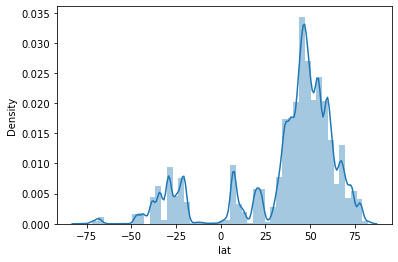

In [16]:
plt.clf()
sns.distplot(df.lat)

## Daily temperature range

Now we turn to looking at the range of temperatures within a day,
known as "diurnal temperature variation".  This range can be
obtained by subtracting the daily minimum from the daily maximum
temperature, both of which are variables in our dataset.  We can
then explore whether the variation in the daily temperature range is
related to the latitude, longitude, or elevation of the station.

In [17]:
df["range"] = df["tmax"] - df["tmin"]

The behavior of temperature ranges differs by season.  To control
for that effect, we select only data from June for this analysis.

In [18]:
dx = df.loc[df.date.dt.month==6, :].copy()

The next plot shows us how the daily temperature range relates to
the latitude at which a station is located.  Note that here we are
running the lowess algorithm directly rather than letting Seaborn
call it for us.  This gives us more control over how the algorithm
runs.

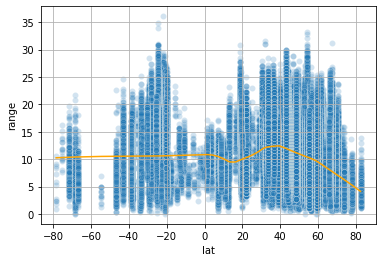

In [19]:
plt.clf()
dx["range_smooth"] = sm.nonparametric.lowess(dx["range"], dx["lat"], return_sorted=False)
sns.scatterplot(x="lat", y="range", alpha=0.2, data=dx)
sns.lineplot(x="lat", y="range_smooth", color="orange", ci=None, data=dx)
plt.grid(True)

The next plot shows us how the daily temperature range relates to
the longitude at which a station is located.

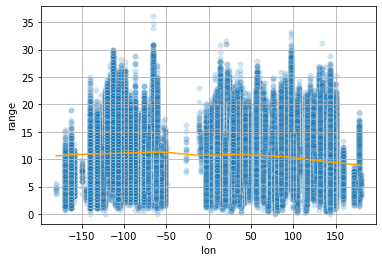

In [20]:
plt.clf()
dx["range_smooth"] = sm.nonparametric.lowess(dx["range"], dx["lon"], return_sorted=False)
sns.scatterplot(x="lon", y="range", alpha=0.2, data=dx)
sns.lineplot(x="lon", y="range_smooth", color="orange", ci=None, data=dx)
plt.grid(True)

This plot shows us how the daily temperature range relates to the
elevation at which a station is located.

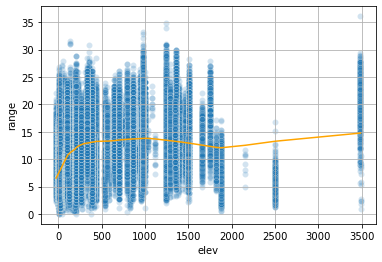

In [21]:
plt.clf()
dx["range_smooth"] = sm.nonparametric.lowess(dx["range"], dx["elev"], return_sorted=False)
sns.scatterplot(x="elev", y="range", alpha=0.2, data=dx)
sns.lineplot(x="elev", y="range_smooth", color="orange", ci=None, data=dx)
plt.grid(True)

The three plots above show that the stations with high latitude or
low elevation tend to have smaller within-day temperature ranges
than the other stations during the month of June.  The low-elevation
stations are near the ocean, and the ocean tends to moderate the
temperature difference between night and day.  We also found that
locations at higher (more northern) latitudes have somewhat less
diurnal variation.  There are several reasons for this, including
humidity, cloud cover, and the long duration of the solar day at
high latitudes in summer.

If you are interested in this topic, see
[here](https://en.m.wikipedia.org/wiki/Diurnal_temperature_variation)
for more information about diurnal temperature variation.